# The Mighty Pileup

In [1]:
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-white')

In [2]:
import multiprocess as mp
import numpy as np
import pandas as pd
import h5py
import scipy.sparse as sps
import bioframe
import cooltools
import cooler
import bbi

In [3]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [13]:
conditions = ['WT', 'dN']
binsize = 100000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

## Single landmark pileup

In [6]:
from cooltools import snipping

In [7]:
ctcf = pd.read_table('data/CtcfCtrl.mm9__VS__InputCtrl.mm9.narrowPeak_with_motif.txt.gz')
ctcf.head()

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,chrom_m,start_m,end_m,name_m,score_m,strand_m,pval_m
0,chr14,73909345,73910139,Peak_1,2864,.,66.97627,286.44055,277.00751,386,chr14,73909703,73909716,CTCF_mouse,12.8061,-,1.610000e-05
1,chr8,73292691,73293764,Peak_10,2288,.,59.05101,228.89639,222.17598,738,chr8,73293454,73293467,CTCF_mouse,14.2242,+,6.080000e-06
2,chr10,99078331,99079198,Peak_100,1567,.,40.02444,156.79012,151.30066,303,chr10,99078650,99078663,CTCF_mouse,19.7758,+,6.020000e-08
3,chr19,44437901,44438397,Peak_1000,741,.,20.84388,74.12866,69.69677,273,chr19,44438190,44438203,CTCF_mouse,15.1212,-,3.280000e-06
4,chr1,145853760,145854152,Peak_10000,355,.,12.38549,35.59266,32.22501,189,chr1,145853924,145853937,CTCF_mouse,17.6242,+,3.710000e-07


In [8]:
sites = ctcf.sort_values('fc', ascending=False).iloc[:1000]
sites.head()

,chrom,start,end,name,score,strand,fc,-log10p,-log10q,relSummit,chrom_m,start_m,end_m,name_m,score_m,strand_m,pval_m
39612,chr2,28440591,28441124,Peak_7,2444,.,67.20400,244.48576,237.52400,289,chr2,28440889,28440902,CTCF_mouse,17.1879,+,5.530000e-07
0,chr14,73909345,73910139,Peak_1,2864,.,66.97627,286.44055,277.00751,386,chr14,73909703,73909716,CTCF_mouse,12.8061,-,1.610000e-05
8403,chr12,85930537,85931240,Peak_18,2221,.,66.84265,222.16884,215.60326,320,chr12,85930837,85930850,CTCF_mouse,17.9212,+,2.800000e-07
5278,chr11,78267090,78267719,Peak_15,2240,.,66.48611,224.05933,217.43312,301,chr11,78267350,78267363,CTCF_mouse,17.9636,-,2.770000e-07
40800,chr11,98203663,98204470,Peak_8,2370,.,65.88831,237.03339,230.20671,426,chr11,98204100,98204113,CTCF_mouse,20.5697,-,2.070000e-08


In [15]:
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

flank = 600000
windows = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom'], 
    (sites['start_m'] + sites['end_m'])//2,
    flank_bp=flank)
windows['strand'] = sites['strand_m']
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()

print(len(windows), 'windows, after assigning supports')
windows.head()

1000 windows, after assigning supports


,chrom,start,end,lo,hi,strand,region
39612,chr2,27800000,29100000,278,291,+,chr2:0-181748087
0,chr14,73300000,74600000,733,746,-,chr14:0-125194864
8403,chr12,85300000,86600000,853,866,+,chr12:0-121257530
5278,chr11,77600000,78900000,776,789,-,chr11:0-121843856
40800,chr11,97600000,98900000,976,989,-,chr11:0-121843856


In [16]:
stacks = {}
piles = {}
for cond in conditions:
    expected = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
    snipper = snipping.ObsExpSnipper(clrs[cond], expected)
    
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    
    # mirror reflect snippets whose feature is on the opposite strand
    mask = np.array(windows.strand == '+', dtype=bool)
    stack[:, :, mask] = stack[::-1, ::-1, mask]
    
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


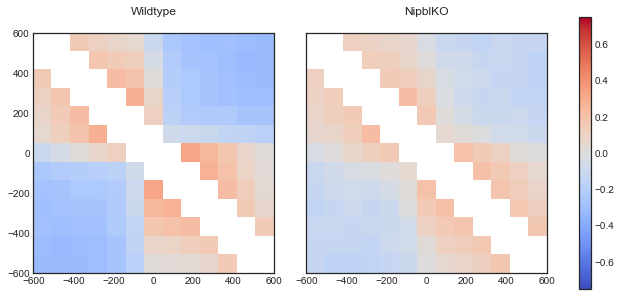

In [17]:
gs = GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
plt.figure(figsize=(5 * len(conditions), 5))

opts = dict(
    vmin=-0.75,
    vmax=0.75,
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

## Piling up paired landmarks

In [27]:
anchor_dist = 300000
anchor_flank = 10000
sites = pd.read_table('data/ctcf-sites.paired.300kb_flank10kb.tsv')
sites = sites[(sites['strand1'] == '+') & (sites['strand2'] == '-')]

In [23]:
snippet_flank = 200000

windows1 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom1'], 
    sites['mid1'],
    flank_bp=snippet_flank)
windows1['strand'] = sites['strand1']

windows2 = snipping.make_bin_aligned_windows(
    binsize, 
    sites['chrom2'], 
    sites['mid2'],
    flank_bp=snippet_flank)
windows2['strand'] = sites['strand2']

windows = pd.merge(windows1, windows2, left_index=True, right_index=True, suffixes=('1', '2'))
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()
windows.head()

,chrom1,start1,end1,lo1,hi1,strand1,chrom2,start2,end2,lo2,hi2,strand2,region
5,chr9,77200000,77700000,772,777,+,chr9,77800000,78300000,778,783,-,chr9:0-124076172
9,chr7,149300000,149800000,1493,1498,+,chr7,149900000,150400000,1499,1504,-,chr7:0-152524553
13,chr12,85100000,85600000,851,856,+,chr12,85700000,86200000,857,862,-,chr12:0-121257530
16,chr12,85100000,85600000,851,856,+,chr12,85700000,86200000,857,862,-,chr12:0-121257530
19,chr9,31100000,31600000,311,316,+,chr9,31700000,32200000,317,322,-,chr9:0-124076172


In [24]:
stacks = {}
piles = {}
for cond in conditions:
    expected = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
    snipper = snipping.ObsExpSnipper(clrs[cond], expected)
    stack = snipping.pileup(windows, snipper.select, snipper.snip)
    stacks[cond] = stack
    piles[cond] = np.nanmean(stack, axis=2)

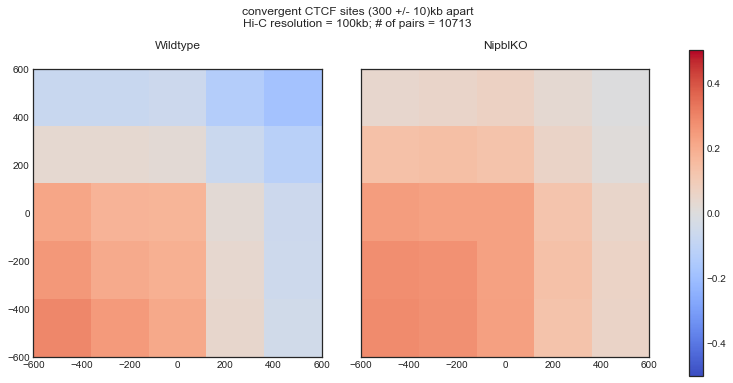

In [28]:
gs = plt.GridSpec(nrows=1, ncols=len(conditions) + 1, width_ratios=[20] * len(conditions) + [1])
plt.figure(figsize=(6 * len(conditions), 6))

opts = dict(
    vmin=-0.5,
    vmax=0.5,
    extent=[-flank//1000, flank//1000, -flank//1000, flank//1000],
    cmap='coolwarm'
)

for i, cond in enumerate(conditions):
    ax = plt.subplot(gs[i])
    img = ax.matshow(
        np.log2(np.nanmean(stacks[cond], axis=2)), #piles[cond]),  
        **opts)
    ax.xaxis.tick_bottom()
    if i > 0:
        ax.yaxis.set_visible(False)
    plt.title(long_names[cond])

ax = plt.subplot(gs[len(conditions)])
plt.colorbar(img, cax=ax)

plt.suptitle(f'convergent CTCF sites ({anchor_dist//1000} +/- {anchor_flank//1000})kb apart\n'
             f'Hi-C resolution = {binsize//1000}kb; # of pairs = {len(windows)}')

## Inspect examples

In [ ]:
from ipywidgets import interact
gs = plt.GridSpec(nrows=1, ncols=2)
plt.figure(figsize=(8, 4))

direc = 'dn'
condx = 'U'
condy = 'N'
n_examples = stacks_x[direc, condx, condy].shape[2]

@interact(i=(0, n_examples-1))
def f(i):
    
    Ax = stacks_x[direc, condx, condy][:,:,i]
    ax = plt.subplot(gs[0])
    ax.matshow(np.log2(Ax), cmap='coolwarm', extent=[-flank//binsize, flank//binsize,
                                                      flank//binsize, -flank//binsize])
    plt.title(condx)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axvline(0, c='g', ls='--', lw=0.5)
    plt.axhline(0, c='g', ls='--', lw=0.5)
    
    Ay = stacks_y[direc, condx, condy][:,:,i]
    ax = plt.subplot(gs[1])
    ax.matshow(np.log2(Ay), cmap='coolwarm', extent=[-flank//binsize, flank//binsize,
                                                      flank//binsize, -flank//binsize])
    plt.title(condy)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.axvline(0, c='g', ls='--', lw=0.5)
    plt.axhline(0, c='g', ls='--', lw=0.5)

    this = windows[direc, condx, condy].iloc[i]
    name = '{}:{:,}'.format(this.chrom, (this.start + this.end)//2)
    plt.suptitle(name)

## Piledriver!

An extremely hacky interactive pileup explorer

In [19]:
import matplotlib as mpl
import seaborn as sns
import bokeh
import numpy as np

from bokeh.io import  output_file, output_notebook, push_notebook
from bokeh.plotting import figure, show, curdoc
from bokeh.layouts import (
    row, 
    column, 
    widgetbox, 
    gridplot,
    layout,
    Spacer,
    GridSpec,
)
from bokeh.models import (
    Range1d,
    GlyphRenderer, 
    LinearColorMapper, 
    LogColorMapper, 
    LogTicker, 
    ColorBar,
    Slider,
    RangeSlider,
    TextInput,
    Select,
    CustomJS,
    CustomJSFilter,
    CustomJSTransform
)

output_notebook()

CALLBACK_TEMPLATE = """
if (IPython.notebook.kernel !== undefined) {{
    var kernel = IPython.notebook.kernel;
    
    arg = "(" + {} + ")"
    cmd = "{}(" + arg + ")";
    kernel.execute(cmd, {{}}, {{}});
}}
"""
SCALAR_ARG = """cb_obj.value"""
TUPLE_ARG = """cb_obj.value[0] + "," + cb_obj.value[1]"""


def make_callback(func, is_tuple=False):
    arg_parsed = TUPLE_ARG if is_tuple else SCALAR_ARG
    return CustomJS(code=CALLBACK_TEMPLATE.format(arg_parsed, func.__name__))


def make_colormapper(cmap, vmin=None, vmax=None, scale='linear'):
    cmap = mpl.cm.get_cmap(cmap)
    palette = [mpl.colors.rgb2hex(rgb) for rgb in cmap(np.arange(cmap.N))]
    mapper_cls = {'linear': LinearColorMapper, 'log': LogColorMapper}[scale]
    return mapper_cls(palette=palette, low=vmin, high=vmax)


def _slider_on_change(value):
    lo, hi = value
    for name in app.snippet_names:
        subset = app.snippets[name][::-1, :, lo:hi]
        img = np.nanmean(subset, axis=2)
        app.images[name].data_source.data['image'] = [img]
    for name in app.track_names:
        app.quads[name].data_source.data['bottom'] = [lo]
        app.quads[name].data_source.data['top'] = [hi]
    push_notebook(handle=bokeh_handle)

    
class PileDriver:
    
    def __init__(self, 
                 tracks, 
                 snippets,  
                 tdims=(350, 750), tflank=None,
                 sdims=(350, 350), sflank=None,
                 cmap_options=None,
                 step=1):
        """

        Parameters
        ----------
        tracks : dict or tuple of (dict, list)
            Dictionary of name -> track stack array (2d). Optionally provide
            a list with subset of keys to use.
        snippets : dict or tuple of (dict, list)
            Dictionary of name -> snippet stack array (3d). Optionally provide
            a list with subset of keys to use.
        flank : int
            Radius to use for defining plot axis extents.
        sdims : tuple (int, int)
            Size of snippet figure in pixels
        tdims : tuple (int, int)
            Size of snippet figure in pixels
        cmap_options : dict
            Nested dict of colormap options for each plot: name -> dict()
            Options are: 
                * 'cmap': a matplotlib colormap object or name of one
                * 'vmin', 'vmax': range of values to map to
                * 'scale': how to map the colors to data ('linear' or 'log')
            Any missing options are substituted with default values.

        """
        if isinstance(tracks, tuple):
            self.tracks, self.track_names = tracks
        else:
            self.tracks, self.track_names = tracks, list(tracks.keys())

        if isinstance(snippets, tuple):
            self.snippets, self.snippet_names = snippets
        else:
            self.snippets, self.snippet_names = snippets, list(snippets.keys())
        
        x = next(iter(self.tracks.values()))
        n_windows = x.shape[0]
        if tflank is None:
            tflank = x.shape[1] // 2
        x = next(iter(self.snippets.values()))
        if sflank is None:
            sflank = x.shape[1] // 2
        
        self.figures = {}
        self.images = {}
        self.widgets = {}
        self.quads = {}
        
        self.dx = self.dy = 2 * sflank
        self.x_range = Range1d(-sflank, sflank)
        self.y_range = Range1d(-sflank, sflank)
        
        self.du =2 * tflank
        self.dv = n_windows
        self.u_range = Range1d(-tflank, tflank)
        self.v_range = Range1d(n_windows, 0)

        self._make_track_plots(tdims[0], tdims[1], cmap_options or {})
        self._make_snippet_plots(sdims[0], sdims[1], cmap_options or {})
        self._make_widgets(step)
    
    def _make_track_plots(self, plot_width, plot_height, color_opts):
        for name in self.track_names:
            self.figures[name] = figure(
                plot_width=plot_width, 
                plot_height=plot_height,
                x_range=self.u_range, 
                y_range=self.v_range,
                title=name,
                x_axis_location="above",
            )
            self.figures[name].title.align = 'center'
            cmap = color_opts.get(name, {}).get('cmap', 'Reds')
            vmin = color_opts.get(name, {}).get('vmin', 0)
            vmax = color_opts.get(name, {}).get('vmax', 2)
            scale = color_opts.get(name, {}).get('scale', 'linear')
            self.images[name] = self.figures[name].image(
                image=[ self.tracks[name][::-1, :] ],
                x=[-self.du/2],
                dw=[self.du],
                y=[self.dv],
                dh=[self.dv], 
                color_mapper=make_colormapper(cmap, vmin, vmax, scale), 
                name='stack1d_' + name
            )
            self.quads[name] = self.figures[name].quad(
                top=[0],
                bottom=[100],
                left=[-self.du/2],
                right=[self.du/2],
                color='#555555',
                alpha=0.6)
        
    def _make_snippet_plots(self, plot_width, plot_height, color_opts):
        for name in self.snippet_names:
            self.figures[name] = figure(
                plot_width=plot_width, 
                plot_height=plot_height,
                x_range=self.x_range, 
                y_range=self.y_range,
                title=name,
            )
            self.figures[name].title.align = 'center'
            cmap = color_opts.get(name, {}).get('cmap', 'coolwarm')
            vmin = color_opts.get(name, {}).get('vmin', 1/1.5)
            vmax = color_opts.get(name, {}).get('vmax', 1.5)
            scale = color_opts.get(name, {}).get('scale', 'log')
            self.images[name] = self.figures[name].image(
                image=[ self.snippets[name][::-1, :, 0] ],
                x=[-self.dx/2], 
                dw=[self.dx],
                y=[-self.dy/2],
                dh=[self.dy], 
                color_mapper=make_colormapper(cmap, vmin, vmax, scale), 
                name='stack2d_' + name
            )
            self.figures[name].line(x=[0, 0], y=[-self.dx/2, self.dx/2])
            self.figures[name].line(x=[-self.dy/2, self.dy/2], y=[0, 0])
        
    def _make_widgets(self, step):
        self.widgets['slider'] = RangeSlider(
            title="snippets", 
            start=0, 
            end=self.dv - 1, 
            step=step, 
            value=(0, 1),
            callback=make_callback(_slider_on_change, is_tuple=True))
    
    def get_layout(self):
        self.layout = layout(
            [self.figures[name] for name in self.snippet_names] + [self.widgets['slider']], 
            [self.figures[name] for name in self.track_names]
        )
        return self.layout

Loading BokehJS ...

In [ ]:
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]

binsize = 10000
cooler_paths = {
    'U': f'/net/levsha/share/lab/TCCSpitz2015/coolers/UNTR.{binsize//1000}kb.cool',
    'T': f'/net/levsha/share/lab/TCCSpitz2015/coolers/TAM.{binsize//1000}kb.cool',
    'N': f'/net/levsha/share/lab/TCCSpitz2015/coolers/NIPBL.{binsize//1000}kb.cool',
    'C': f'/net/levsha/share/lab/TCCSpitz2015/coolers/NCAPH2.{binsize//1000}kb.cool',
}
clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

sflank = 250000
windows = snipping.make_bin_aligned_windows(
    binsize, 
    PE['chrom'], 
    PE['start'].where(PE['strand'] == '+', PE['end']),
    flank_bp=sflank)
windows['strand'] = PE['strand']
windows = snipping.assign_regions(windows, supports)
windows = windows.dropna()
print(len(windows), 'windows, after assigning supports')

stacks2d = {}
piles = {}
with mp.Pool(len(supports)) as pool:
    for cond in conditions:
        expected = pd.read_table(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv')
        snipper = snipping.ObsExpSnipper(clrs[cond], expected)
        stack = snipping.pileup(windows, snipper.select, snipper.snip, map=pool.map)
        mask = np.array(windows.strand == '+', dtype=bool)
        stack[:, :, mask] = stack[::-1, ::-1, mask]
        stacks2d[cond] = stack
        piles[cond] = np.nanmean(stack, axis=2)